In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import ast
import xarray as xr
import matplotlib.pyplot as plt
from src.data_generator import *
from src.train import *
from src.utils import *
from src.clr import *

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(1)

In [5]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [6]:
args = load_args('../nn_configs/B/81-resnet_d3_dr_0.1.yml')
args['exp_id'] = '81.1-resnet_d3_dr_0.1.yml'

In [7]:
ds = xr.merge(
    [xr.open_mfdataset(f'{args["datadir"]}/{var}/*.nc', combine='by_coords')
     for var in args["var_dict"].keys()],
    fill_value=0  # For the 'tisr' NaNs
)

In [9]:
ds_train = ds.sel(time=slice('2015-01', '2015-02'))

## Difference to input

In [10]:
dg = DataGenerator(ds_train, args['var_dict'], 72, shuffle=False, output_vars=args['output_vars'])

In [11]:
X, y = dg[0]

In [12]:
X.shape, y.shape

((32, 32, 64, 38), (32, 32, 64, 2))

In [18]:
dg.data.level_names[2].values

array('z_500', dtype='<U9')

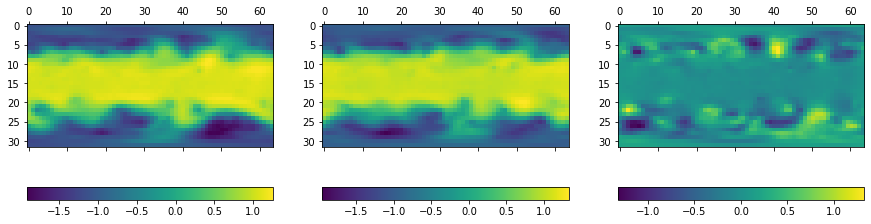

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
I = ax1.matshow(X[0, ..., 2])
fig.colorbar(I, ax=ax1, orientation='horizontal');
I = ax2.matshow(y[0, ..., 0])
fig.colorbar(I, ax=ax2, orientation='horizontal');
I = ax3.matshow(y[0, ..., 0]-X[0, ..., 2])
fig.colorbar(I, ax=ax3, orientation='horizontal');

In [24]:
dg = DataGenerator(ds_train, args['var_dict'], 72, shuffle=False, output_vars=args['output_vars'],
                   predict_difference=True)

In [77]:
X, y = dg[0]

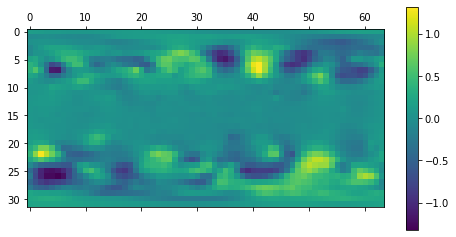

In [78]:
plt.matshow(y[0, ..., 0])
plt.colorbar();

Seems to work! Started test run 027

## Categorical

In [63]:
lead_time=72
d = dg.data.isel(level=dg.output_idxs).values
diff = d[lead_time:] - d[:-lead_time]

In [64]:
diff.shape

(1344, 32, 64, 2)

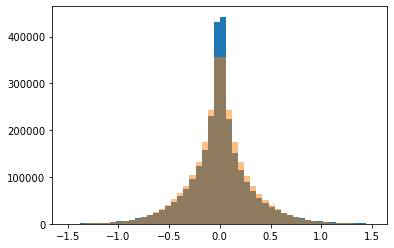

In [65]:
plt.hist(diff[..., 0].flat, bins=np.linspace(-1.5, 1.5, 51))
plt.hist(diff[..., 1].flat, alpha=0.5,bins= np.linspace(-1.5, 1.5, 51));

In [66]:
np.diff(np.linspace(-1.5, 1.5, 50))[0]

0.061224489795918435

In [67]:
dg.std[12].values * 0.061224489795918435

0.9262601905529565

In [69]:
bins = np.linspace(-1.5, 1.5, 51)
bins[0] = -np.inf; bins[-1] = np.inf

In [72]:
import pandas as pd

In [83]:
y_shape=y.shape
y_cat=pd.cut(y.reshape(-1), bins, labels=False).reshape(y_shape)
y_cat=tf.keras.utils.to_categorical(y_cat, num_classes=50)

In [86]:
y[1, 8, 0, 0], y_cat[1, 8, 0, 0]

(0.23679571,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32))

In [76]:
y.shape

(32, 32, 64, 2, 50)

In [89]:
dg = DataGenerator(ds_train, args['var_dict'], 72, shuffle=False, output_vars=args['output_vars'],
                   predict_difference=True, is_categorical=True, bin_min=-1.5, bin_max=1.5, num_bins=50)

In [90]:
X, y = dg[0]

In [91]:
y.shape

(32, 32, 64, 2, 50)

In [94]:
y[1, 8, 0, 0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

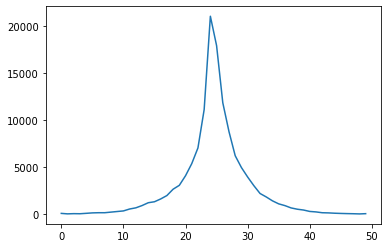

In [96]:
plt.plot(y.sum((0, 1, 2, 3)))

So this works as well.

## Model for categorical

In [97]:
from src.networks import *

In [103]:
model = build_resnet([128, 128, 128, 100], [7, 3, 3, 3], dg.shape, categorical=True, nvars=len(dg.output_idxs))

In [104]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 64, 38)] 0                                            
__________________________________________________________________________________________________
periodic_conv2d_12 (PeriodicCon (None, 32, 64, 128)  238464      input_3[0][0]                    
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 32, 64, 128)  0           periodic_conv2d_12[0][0]         
__________________________________________________________________________________________________
periodic_conv2d_13 (PeriodicCon (None, 32, 64, 128)  147584      activation_11[0][0]              
____________________________________________________________________________________________

In [117]:
def create_lat_categorical_loss(lat, nvars):
    weights_lat = np.cos(np.deg2rad(lat)).values
    weights_lat /= weights_lat.mean()

    def categorical_loss(y_true, y_pred):    
        cce = tf.keras.losses.categorical_crossentropy
        loss = 0 #is this ok?
        for i in range(nvars):
            loss += cce(y_true[:,:,:,i,:], y_pred[:,:,:,i,:])*weights_lat[None, :, None]
        return loss    
    return categorical_loss

In [118]:
cat_loss = create_lat_categorical_loss(dg.data.lat, nvars=len(dg.output_idxs))

In [119]:
p = model(X)

In [108]:
p.shape

TensorShape([32, 32, 64, 2, 50])

In [122]:
p.numpy()[0, 0, 0, 0].sum()

0.9999695

In [110]:
y.shape

(32, 32, 64, 2, 50)

In [120]:
l = cat_loss(y, p)

In [121]:
l.shape

TensorShape([32, 32, 64])

In [123]:
model.compile('adam', cat_loss)

In [125]:
model.fit(dg, epochs=100)

Epoch 1/100
42/42 [==============================] - 2s 49ms/step - loss: 2.6266
Epoch 2/100
42/42 [==============================] - 2s 56ms/step - loss: 2.6411
Epoch 3/100
42/42 [==============================] - 2s 54ms/step - loss: 2.6768
Epoch 4/100
42/42 [==============================] - 2s 52ms/step - loss: 2.6966
Epoch 5/100
42/42 [==============================] - 2s 55ms/step - loss: 2.7050
Epoch 6/100
42/42 [==============================] - 2s 57ms/step - loss: 2.6294
Epoch 7/100
42/42 [==============================] - 2s 54ms/step - loss: 2.5907
Epoch 8/100
42/42 [==============================] - 2s 57ms/step - loss: 2.5940
Epoch 9/100
42/42 [==============================] - 2s 50ms/step - loss: 2.5807
Epoch 10/100
42/42 [==============================] - 2s 48ms/step - loss: 2.5578
Epoch 11/100
42/42 [==============================] - 2s 48ms/step - loss: 2.6401
Epoch 12/100
42/42 [==============================] - 2s 48ms/step - loss: 2.6767
Epoch 13/100
42/42 [=====

In [129]:
p = model.predict(X)

In [130]:
p.shape

(32, 32, 64, 2, 50)

<BarContainer object of 50 artists>

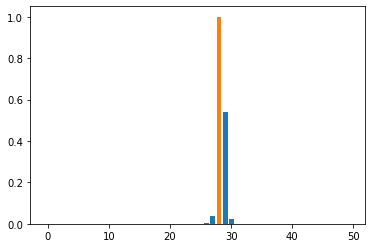

In [133]:
plt.bar(np.arange(50), p[0, 8, 0, 0])
plt.bar(np.arange(50), y[0, 8, 0, 0])

Seems to work somewhat, let's test it with the full data.

## Load trained model

In [6]:
args = load_args('../nn_configs/C/028-resnet_d3_ztt_3d_cat.yml')

In [7]:
args['ext_mean'] = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
args['ext_std'] = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")

In [9]:
dg_test = load_data(**args, only_test=True)

In [11]:
model = load_model(args)

In [13]:
X, y = dg_test[0]

In [26]:
truth = []
for X, y in dg_test:
    truth.append(y)

In [27]:
truth = np.concatenate(truth)

In [29]:
truth.shape

(8718, 32, 64, 2, 50)

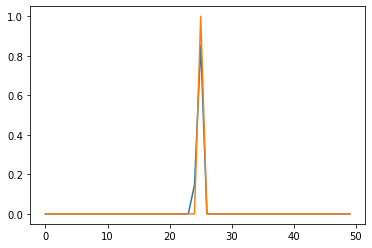

In [24]:
plt.plot(preds[0, 16, 0, 0])
plt.plot(y[0, 16, 0, 0])

In [30]:
np.save('/home/rasp/data/myWeatherBench/predictions_C/028_cat.npy', preds)
np.save('/home/rasp/data/myWeatherBench/predictions_C/028_cat_truth.npy', truth)